# **AI Inference Accelerator**

This notebook presents the design of an AI accelerator, which can then be integrated with other systems such as embedded applications — UAVs, UGVs, consumer electronics, and more.



---

## Introduction

The AI inference accelerator features specialized hardware designed and optimized for inference, the process of producing predictions done by an AI model. It serves to ease, speed up, and lower the cost of AI integration in numerous systems and can be used during either development, deployment, or both. For systems with strong constraints, such as embedded applications, this can be a gamechanger.

Here, we present the design of an AI inference accelerator implemented using open source tools. Using the QSPI (Quad Serial Peripheral Interface), the AI inference accelerator can be easily integrated with a host microcontroller as well as a NAND/NOR flash memory while taking advantage of its relatively high throughput.

### Authors
All team members are affliated with Institut Teknologi Bandung, Indonesia.

* Surya Dharma (13220027@mahasiswa.itb.ac.id)
* Gotawa Aryo Prakoso (13220030@mahasiswa.itb.ac.id)
* Emmanuella Rumanti (13220031@mahasiswa.itb.ac.id)
* Muhammad Daffa Rasyid (13220059@mahasiswa.itb.ac.id)
* Muhammad Ali (13219017@mahasiswa.itb.ac.id)


### Tools
Sky130A PDK version 1.0.471 or newer.

## Design

### Top-Level Design

The processor consists of three main units, as shown on the internal block diagram below.

* **Simplified RISC-V Processor Core:** This is a stripped-down RISC-V processor core designed solely to manage the data flow within the chip. Being a simplified version of the RISC-V ISA, it will only incorporate the most essential instructions necessary for chip operations. These are `load word`, `store word`, and `branch if equal`.

* **AI Inference Accelerator Unit**: This is the primary block of the inference accelerator unit, responsible for computing outputs based on input, weight, bias, and activation function (which, based on user selection, be either ReLU or the sigmoid function).

* **QSPI Interface**: This serves as both the input and output interface of the chip. QSPI (Quad Serial Peripheral Interface) has been selected due to its relatively high throughput. The chip will feature two QSPI channels: one for communication with the host microcontroller and the other for communication with the NAND/NOR flash.


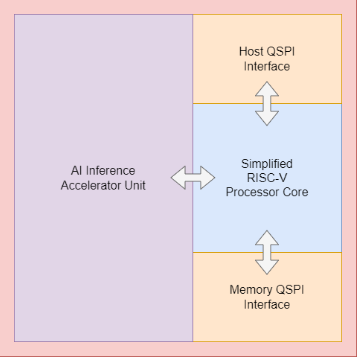

### Intended Use Case
The intended use case involves integrating AI into embedded system applications, such as UAVs, UGVs, and consumer electronics. The main controller will send input data to the accelerator. The accelerator will then process the inference based on the models stored in the external QSPI NAND/NOR flash memory. The inference result will be temporarily stored in the external flash memory, and the data ready pin will be set high. Upon receiving a send data command, the inference result will be sent back to the host microcontroller.

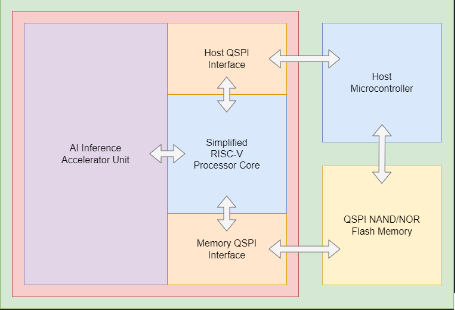

## Implementation

### Environment and Dependencies

In [ ]:
#@title Install dependencies {display-mode: "form"}
#@markdown - Click the ▷ button to setup the digital design environment based on [conda-eda](https://github.com/hdl/conda-eda).

openlane_version = 'latest' #@param {type:"string"}
open_pdks_version = 'latest' #@param {type:"string"}

if openlane_version == 'latest':
  openlane_version = ''
if open_pdks_version == 'latest':
  open_pdks_version = ''

import os
import pathlib

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!CI=0 bin/micromamba install --yes --prefix $CONDA_PREFIX \
                     --channel litex-hub \
                     --channel main \
                     openlane={openlane_version} \
                     open_pdks.sky130a={open_pdks_version}
!python -m pip install gdstk gdstk
PATH = os.environ['PATH']
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}

/bin/bash: /content/conda-env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /content/conda-env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Empty environment created at prefix: /content/conda-env

Pinned packages:
  - python 3.7*


Transaction

  Prefix: /content/conda-env

  Updating specs:

   - openlane=*
   - open_pdks.sky130a=*


  Package                                                Version  Build                 Channel         Size
──────────────────────────────────────────────────────────────────────────────────────────────────────────────
  Install:
──────────────────────────────────────────────────────────────────────────────────────────────────────────────

  + open_pdks.sky130a                         1.0.471_0_g97d0844  20240223_100318       litex-hub     Cached
  + _libgcc_mutex                                            0.1  main                  main          Cached
  + libstdcxx-ng              

In [ ]:
import pandas as pd
import math
import PIL
import cairosvg

from google.colab import files

In [ ]:
!mkdir src

/bin/bash: /content/conda-env/lib/libtinfo.so.6: no version information available (required by /bin/bash)


### RTL (Verilog)

#### Helper Modules

In [ ]:
%%writefile src/adder.v

module adder(
    input  wire [31:0] IN0,
    input  wire [31:0] IN1,
    output wire [31:0] OUT);

    assign OUT = IN0 + IN1;
endmodule

Overwriting src/adder.v


In [ ]:
%%writefile src/multiplier.v

module multiplier(
    input  wire [31:0] IN0,
    input  wire [31:0] IN1,
    output wire [31:0] OUT);

    wire signed [63:0] temp;

    assign temp = IN0 * IN1;
    assign OUT  = temp[63:32];

endmodule


Overwriting src/multiplier.v


In [ ]:
%%writefile src/accumulator.v

module accumulator(
    input wire PULSE, RST,
    input wire [31:0] D,
    output reg [31:0] Q);

    always @(posedge PULSE or posedge RST)
    begin
        if (RST)
            Q <= 32'b0;
        else
            Q <= D;
    end
endmodule


Overwriting src/accumulator.v


In [ ]:
%%writefile src/multiplexer.v

module multiplexer(
    input  wire SEL,
    input  wire [31:0] IN0,
    input  wire [31:0] IN1,
    output wire [31:0] OUT);

    assign OUT = SEL? IN1 : IN0;
endmodule


Overwriting src/multiplexer.v


#### Activation Functions

In [ ]:
%%writefile src/rectified_linear_unit.v

module rectified_linear_unit(
    input  wire [31:0] IN,
    output wire [31:0] OUT);

    wire is_negative = IN[31];

    assign OUT = is_negative ? 32'b0 : IN;
endmodule


Overwriting src/rectified_linear_unit.v


In [ ]:
%%writefile src/sigmoid.v

module sigmoid(
    input wire [31:0] IN,
    output reg [31:0] OUT);

    reg [31:0] mem [0:255];

    initial begin
    // for zero and positive value
        // Start at 0.0000 and end at 0.93750
        mem[8'b0000_0000]=32'b00000000100000000000000000000000;
        mem[8'b0000_0001]=32'b00000000100000111111111110101011;
        mem[8'b0000_0010]=32'b00000000100001111111110101010110;
        mem[8'b0000_0011]=32'b00000000100010111111011100001000;
        mem[8'b0000_0100]=32'b00000000100011111110101011001101;
        mem[8'b0000_0101]=32'b00000000100100111101011010111100;
        mem[8'b0000_0110]=32'b00000000100101111011100100000000;
        mem[8'b0000_0111]=32'b00000000100110111000111111010000;
        mem[8'b0000_1000]=32'b00000000100111110101100101111111;
        mem[8'b0000_1001]=32'b00000000101000110001010001110011;
        mem[8'b0000_1010]=32'b00000000101001101011111100110001;
        mem[8'b0000_1011]=32'b00000000101010100101100001011001;
        mem[8'b0000_1100]=32'b00000000101011011101111010101000;
        mem[8'b0000_1101]=32'b00000000101100010101000011111100;
        mem[8'b0000_1110]=32'b00000000101101001010111001010100;
        mem[8'b0000_1111]=32'b00000000101101111111010111001101;

        // Start at 1.0000 and end at 1.93750
        mem[8'b0001_0000]=32'b00000000101110110010011010101000;
        mem[8'b0001_0001]=32'b00000000101111100100000001000010;
        mem[8'b0001_0010]=32'b00000000110000010100001000011100;
        mem[8'b0001_0011]=32'b00000000110001000010101111010010;
        mem[8'b0001_0100]=32'b00000000110001101111110100100000;
        mem[8'b0001_0101]=32'b00000000110010011011010111011100;
        mem[8'b0001_0110]=32'b00000000110011000101010111111000;
        mem[8'b0001_0111]=32'b00000000110011101101110101111110;
        mem[8'b0001_1000]=32'b00000000110100010100110010010000;
        mem[8'b0001_1001]=32'b00000000110100111010001101100010;
        mem[8'b0001_1010]=32'b00000000110101011110001001000000;
        mem[8'b0001_1011]=32'b00000000110110000000100110000010;
        mem[8'b0001_1100]=32'b00000000110110100001100110010100;
        mem[8'b0001_1101]=32'b00000000110111000001001011101100;
        mem[8'b0001_1110]=32'b00000000110111011111011000001110;
        mem[8'b0001_1111]=32'b00000000110111111100001110000111;

        // Start at 2.0000 and end at 2.93750
        mem[8'b0010_0000]=32'b00000000111000010111101111101011;
        mem[8'b0010_0001]=32'b00000000111000110001111111010111;
        mem[8'b0010_0010]=32'b00000000111001001010111111101101;
        mem[8'b0010_0011]=32'b00000000111001100010110011010010;
        mem[8'b0010_0100]=32'b00000000111001111001011100101101;
        mem[8'b0010_0101]=32'b00000000111010001110111110101010;
        mem[8'b0010_0110]=32'b00000000111010100011011011110011;
        mem[8'b0010_0111]=32'b00000000111010110110110110110001;
        mem[8'b0010_1000]=32'b00000000111011001001010010001111;
        mem[8'b0010_1001]=32'b00000000111011011010110000110011;
        mem[8'b0010_1010]=32'b00000000111011101011010101000011;
        mem[8'b0010_1011]=32'b00000000111011111011000001100000;
        mem[8'b0010_1100]=32'b00000000111100001001111000101001;
        mem[8'b0010_1101]=32'b00000000111100010111111100111010;
        mem[8'b0010_1110]=32'b00000000111100100101010000101001;
        mem[8'b0010_1111]=32'b00000000111100110001110110001000;

        // Start at 3.0000 and end at 3.93750
        mem[8'b0011_0000]=32'b00000000111100111101101111100110;
        mem[8'b0011_0001]=32'b00000000111101001000111111001011;
        mem[8'b0011_0010]=32'b00000000111101010011100110111101;
        mem[8'b0011_0011]=32'b00000000111101011101101000111011;
        mem[8'b0011_0100]=32'b00000000111101100111000110111111;
        mem[8'b0011_0101]=32'b00000000111101110000000010111111;
        mem[8'b0011_0110]=32'b00000000111101111000011110101101;
        mem[8'b0011_0111]=32'b00000000111110000000011011110101;
        mem[8'b0011_1000]=32'b00000000111110000111111011111110;
        mem[8'b0011_1001]=32'b00000000111110001111000000101100;
        mem[8'b0011_1010]=32'b00000000111110010101101011011100;
        mem[8'b0011_1011]=32'b00000000111110011011111101101001;
        mem[8'b0011_1100]=32'b00000000111110100001111000101000;
        mem[8'b0011_1101]=32'b00000000111110100111011101101011;
        mem[8'b0011_1110]=32'b00000000111110101100101110000000;
        mem[8'b0011_1111]=32'b00000000111110110001101010110000;

        // Start at 4.0000 and end at 4.93750
        mem[8'b0100_0000]=32'b00000000111110110110010101000001;
        mem[8'b0100_0001]=32'b00000000111110111010101101110111;
        mem[8'b0100_0010]=32'b00000000111110111110110110001111;
        mem[8'b0100_0011]=32'b00000000111111000010101111000110;
        mem[8'b0100_0100]=32'b00000000111111000110011001010011;
        mem[8'b0100_0101]=32'b00000000111111001001110101101110;
        mem[8'b0100_0110]=32'b00000000111111001101000101001000;
        mem[8'b0100_0111]=32'b00000000111111010000001000010000;
        mem[8'b0100_1000]=32'b00000000111111010010111111110110;
        mem[8'b0100_1001]=32'b00000000111111010101101100100010;
        mem[8'b0100_1010]=32'b00000000111111011000001110111111;
        mem[8'b0100_1011]=32'b00000000111111011010100111110001;
        mem[8'b0100_1100]=32'b00000000111111011100110111011110;
        mem[8'b0100_1101]=32'b00000000111111011100110111011110;
        mem[8'b0100_1110]=32'b00000000111111100000111101101011;
        mem[8'b0100_1111]=32'b00000000111111100010110101001010;

        // Start at 5.0000 and end at 5.93750
        mem[8'b0101_0000]=32'b00000000111111100100100101100001;
        mem[8'b0101_0001]=32'b00000000111111100110001111001001;
        mem[8'b0101_0010]=32'b00000000111111100111110010011101;
        mem[8'b0101_0011]=32'b00000000111111101001001111110100;
        mem[8'b0101_0100]=32'b00000000111111101010100111100101;
        mem[8'b0101_0101]=32'b00000000111111101011111010000101;
        mem[8'b0101_0110]=32'b00000000111111101101000111101000;
        mem[8'b0101_0111]=32'b00000000111111101110010000100001;
        mem[8'b0101_1000]=32'b00000000111111101111010101000010;
        mem[8'b0101_1001]=32'b00000000111111110000010101011100;
        mem[8'b0101_1010]=32'b00000000111111110001010001111101;
        mem[8'b0101_1011]=32'b00000000111111110010001010110110;
        mem[8'b0101_1100]=32'b00000000111111110011000000010011;
        mem[8'b0101_1101]=32'b00000000111111110011110010100011;
        mem[8'b0101_1110]=32'b00000000111111110100100001110000;
        mem[8'b0101_1111]=32'b00000000111111110101001110001000;

        // Start at 6.0000 and end at 6.93750
        mem[8'b0110_0000]=32'b00000000111111110101110111110100;
        mem[8'b0110_0001]=32'b00000000111111110110011111000000;
        mem[8'b0110_0010]=32'b00000000111111110111000011110100;
        mem[8'b0110_0011]=32'b00000000111111110111100110011010;
        mem[8'b0110_0100]=32'b00000000111111111000000110111011;
        mem[8'b0110_0101]=32'b00000000111111111000100101011110;
        mem[8'b0110_0110]=32'b00000000111111111001000010001011;
        mem[8'b0110_0111]=32'b00000000111111111001011101001001;
        mem[8'b0110_1000]=32'b00000000111111111001110110011110;
        mem[8'b0110_1001]=32'b00000000111111111010001110010010;
        mem[8'b0110_1010]=32'b00000000111111111010100100101010;
        mem[8'b0110_1011]=32'b00000000111111111010111001101011;
        mem[8'b0110_1100]=32'b00000000111111111011001101011011;
        mem[8'b0110_1101]=32'b00000000111111111011011111111110;
        mem[8'b0110_1110]=32'b00000000111111111011110001011010;
        mem[8'b0110_1111]=32'b00000000111111111100000001110010;

        // Start at 7.0000 and end at 7.93750
        mem[8'b0111_0000]=32'b00000000111111111100010001001011;
        mem[8'b0111_0001]=32'b00000000111111111100011111101000;
        mem[8'b0111_0010]=32'b00000000111111111100101101001110;
        mem[8'b0111_0011]=32'b00000000111111111100111001111110;
        mem[8'b0111_0100]=32'b00000000111111111101000101111110;
        mem[8'b0111_0101]=32'b00000000111111111101010001001111;
        mem[8'b0111_0110]=32'b00000000111111111101011011110100;
        mem[8'b0111_0111]=32'b00000000111111111101100101110000;
        mem[8'b0111_1000]=32'b00000000111111111101101111000110;
        mem[8'b0111_1001]=32'b00000000111111111101110111111000;
        mem[8'b0111_1010]=32'b00000000111111111110000000000111;
        mem[8'b0111_1011]=32'b00000000111111111110000111110111;
        mem[8'b0111_1100]=32'b00000000111111111110001111001000;
        mem[8'b0111_1101]=32'b00000000111111111110010101111110;
        mem[8'b0111_1110]=32'b00000000111111111110011100011001;
        mem[8'b0111_1111]=32'b00000000111111111110100010011011;

    // for negative value
        // Start at -1.0000 and end at -0.0625
        mem[8'b11110000]=32'b00000000010001001101100101011000;
        mem[8'b11110001]=32'b00000000010010000000101000110011;
        mem[8'b11110010]=32'b00000000010010110101000110101100;
        mem[8'b11110011]=32'b00000000010011101010111100000100;
        mem[8'b11110100]=32'b00000000010100100010000101011000;
        mem[8'b11110101]=32'b00000000010101011010011110100111;
        mem[8'b11110110]=32'b00000000010110010100000011001111;
        mem[8'b11110111]=32'b00000000010111001110101110001101;
        mem[8'b11111000]=32'b00000000011000001010011010000001;
        mem[8'b11111001]=32'b00000000011001000111000000110000;
        mem[8'b11111010]=32'b00000000011010000100011100000000;
        mem[8'b11111011]=32'b00000000011011000010100101000100;
        mem[8'b11111100]=32'b00000000011100000001010100110011;
        mem[8'b11111101]=32'b00000000011101000000100011111000;
        mem[8'b11111110]=32'b00000000011110000000001010101010;
        mem[8'b11111111]=32'b00000000011111000000000001010101;

        // Start at -2.0000 and end at -1.0625
        mem[8'b11100000]=32'b00000000000111101000010000010101;
        mem[8'b11100001]=32'b00000000001000000011110001111001;
        mem[8'b11100010]=32'b00000000001000100000100111110010;
        mem[8'b11100011]=32'b00000000001000111110110100010100;
        mem[8'b11100100]=32'b00000000001001011110011001101100;
        mem[8'b11100101]=32'b00000000001001111111011001111110;
        mem[8'b11100110]=32'b00000000001010100001110111000000;
        mem[8'b11100111]=32'b00000000001011000101110010011110;
        mem[8'b11101000]=32'b00000000001011101011001101110000;
        mem[8'b11101001]=32'b00000000001100010010001010000010;
        mem[8'b11101010]=32'b00000000001100111010101000001000;
        mem[8'b11101011]=32'b00000000001101100100101000100100;
        mem[8'b11101100]=32'b00000000001110010000001011100000;
        mem[8'b11101101]=32'b00000000001110111101010000101110;
        mem[8'b11101110]=32'b00000000001111101011110111100100;
        mem[8'b11101111]=32'b00000000010000011011111110111110;


        // Start at -3.0000 and end at -2.0625
        mem[8'b11010000]=32'b00000000000011000010010000011010;
        mem[8'b11010001]=32'b00000000000011001110001001111000;
        mem[8'b11010010]=32'b00000000000011011010101111010111;
        mem[8'b11010011]=32'b00000000000011101000000011000110;
        mem[8'b11010100]=32'b00000000000011110110000111010111;
        mem[8'b11010101]=32'b00000000000100000100111110100000;
        mem[8'b11010110]=32'b00000000000100010100101010111101;
        mem[8'b11010111]=32'b00000000000100100101001111001101;
        mem[8'b11011000]=32'b00000000000100110110101101110001;
        mem[8'b11011001]=32'b00000000000101001001001001001111;
        mem[8'b11011010]=32'b00000000000101011100100100001101;
        mem[8'b11011011]=32'b00000000000101110001000001010110;
        mem[8'b11011100]=32'b00000000000110000110100011010011;
        mem[8'b11011101]=32'b00000000000110011101001100101110;
        mem[8'b11011110]=32'b00000000000110110101000000010011;
        mem[8'b11011111]=32'b00000000000111001110000000101001;

        // Start at -4.0000 and end at -3.0625
        mem[8'b11000000]=32'b00000000000001001001101010111111;
        mem[8'b11000001]=32'b00000000000001001110010101010000;
        mem[8'b11000010]=32'b00000000000001010011010010000000;
        mem[8'b11000011]=32'b00000000000001011000100010010101;
        mem[8'b11000100]=32'b00000000000001011110000111011000;
        mem[8'b11000101]=32'b00000000000001100100000010010111;
        mem[8'b11000110]=32'b00000000000001101010010100100100;
        mem[8'b11000111]=32'b00000000000001110000111111010100;
        mem[8'b11001000]=32'b00000000000001111000000100000010;
        mem[8'b11001001]=32'b00000000000001111111100100001011;
        mem[8'b11001010]=32'b00000000000010000111100001010011;
        mem[8'b11001011]=32'b00000000000010001111111101000001;
        mem[8'b11001100]=32'b00000000000010011000111001000001;
        mem[8'b11001101]=32'b00000000000010100010010111000101;
        mem[8'b11001110]=32'b00000000000010101100011001000011;
        mem[8'b11001111]=32'b00000000000010110111000000110101;

        // Start at -5.0000 and end at -4.0625
        mem[8'b10110000]=32'b00000000000000011011011010011111;
        mem[8'b10110001]=32'b00000000000000011101001010110110;
        mem[8'b10110010]=32'b00000000000000011111000010010101;
        mem[8'b10110011]=32'b00000000000000100001000001011010;
        mem[8'b10110100]=32'b00000000000000100011001000100010;
        mem[8'b10110101]=32'b00000000000000100101011000001111;
        mem[8'b10110110]=32'b00000000000000100111110001000001;
        mem[8'b10110111]=32'b00000000000000101010010011011110;
        mem[8'b10111000]=32'b00000000000000101101000000001010;
        mem[8'b10111001]=32'b00000000000000101111110111110000;
        mem[8'b10111010]=32'b00000000000000110010111010111000;
        mem[8'b10111011]=32'b00000000000000110110001010010010;
        mem[8'b10111100]=32'b00000000000000111001100110101101;
        mem[8'b10111101]=32'b00000000000000111101010000111010;
        mem[8'b10111110]=32'b00000000000001000001001001110001;
        mem[8'b10111111]=32'b00000000000001000101010010001001;

        // Start at -6.0000 and end at -5.0625
        mem[8'b10100000]=32'b00000000000000001010001000001100;
        mem[8'b10100001]=32'b00000000000000001010110001111000;
        mem[8'b10100010]=32'b00000000000000001011011110010000;
        mem[8'b10100011]=32'b00000000000000001100001101011101;
        mem[8'b10100100]=32'b00000000000000001100111111101101;
        mem[8'b10100101]=32'b00000000000000001101110101001010;
        mem[8'b10100110]=32'b00000000000000001110101110000011;
        mem[8'b10100111]=32'b00000000000000001111101010100100;
        mem[8'b10101000]=32'b00000000000000010000101010111110;
        mem[8'b10101001]=32'b00000000000000010001101111011111;
        mem[8'b10101010]=32'b00000000000000010010111000011000;
        mem[8'b10101011]=32'b00000000000000010100000101111011;
        mem[8'b10101100]=32'b00000000000000010101011000011011;
        mem[8'b10101101]=32'b00000000000000010110110000001100;
        mem[8'b10101110]=32'b00000000000000011000001101100011;
        mem[8'b10101111]=32'b00000000000000011001110000110111;

        // Start at -7.0000 and end at -6.0625
        mem[8'b10010000]=32'b00000000000000000011101110110101;
        mem[8'b10010001]=32'b00000000000000000011111110001110;
        mem[8'b10010010]=32'b00000000000000000100001110100110;
        mem[8'b10010011]=32'b00000000000000000100100000000010;
        mem[8'b10010100]=32'b00000000000000000100110010100101;
        mem[8'b10010101]=32'b00000000000000000101000110010101;
        mem[8'b10010110]=32'b00000000000000000101011011010110;
        mem[8'b10010111]=32'b00000000000000000101110001101110;
        mem[8'b10011000]=32'b00000000000000000110001001100010;
        mem[8'b10011001]=32'b00000000000000000110100010110111;
        mem[8'b10011010]=32'b00000000000000000110111101110101;
        mem[8'b10011011]=32'b00000000000000000111011010100010;
        mem[8'b10011100]=32'b00000000000000000111111001000101;
        mem[8'b10011101]=32'b00000000000000001000011001100110;
        mem[8'b10011110]=32'b00000000000000001000111100001100;
        mem[8'b10011111]=32'b00000000000000001001100001000000;

        // Start at -8.0000 and end at -7.0625
        mem[8'b10000000]=32'b00000000000000000001010111111010;
        mem[8'b10000001]=32'b00000000000000000001011101100101;
        mem[8'b10000010]=32'b00000000000000000001100011100111;
        mem[8'b10000011]=32'b00000000000000000001101010000010;
        mem[8'b10000100]=32'b00000000000000000001110000111000;
        mem[8'b10000101]=32'b00000000000000000001111000001001;
        mem[8'b10000110]=32'b00000000000000000001111111111001;
        mem[8'b10000111]=32'b00000000000000000010001000001000;
        mem[8'b10001000]=32'b00000000000000000010010000111010;
        mem[8'b10001001]=32'b00000000000000000010011010010000;
        mem[8'b10001010]=32'b00000000000000000010100100001100;
        mem[8'b10001011]=32'b00000000000000000010101110110001;
        mem[8'b10001100]=32'b00000000000000000010111010000010;
        mem[8'b10001101]=32'b00000000000000000011000110000010;
        mem[8'b10001110]=32'b00000000000000000011010010110010;
        mem[8'b10001111]=32'b00000000000000000011100000011000;
    end

    always@(IN) begin
        if (IN[31:27] == 5'b00000) begin          // value 0 until +8
            OUT <= mem[{1'b0, IN[26:20]}];
        end else if (IN[31:27] == 5'b11111) begin // value 0 until -8
            OUT <= mem[{1'b1, IN[26:20]}];
        end else if(IN[31] == 1'b0) begin         // value above +8
            OUT <= 32'b00000001000000000000000000000000;
        end else begin                            // value under -8
            OUT <= 32'b00000000000000000000000000000000;
        end
    end

endmodule


Overwriting src/sigmoid.v


#### Inference Accelerator Unit

In [ ]:
%%writefile src/register_bank.v

module register_bank(
    // processor core
    input wire  [4:0] READ_ADDR1,
    input wire  [4:0] READ_ADDR2,
    input wire  [4:0] WRITE_ADDR,
    input wire        WRITE_EN,
    // interface to memory (QSPI)
    input wire [31:0] WRITE_DATA,
    output reg [31:0] READ_DATA2,
    // interface to host controller (QSPI)
    output reg [31:0] READ_DATA1,
    // accelerator cell ch1
    output reg CH1_CALC_DATA,
    output reg CH1_RST,
    output reg CH1_RELU_SEL,
    output reg [31:0] CH1_WEIGHT,
    output reg [31:0] CH1_DATA,
    input wire [31:0] CH1_RESULT,
    // accelerator cell ch2
    output reg CH2_CALC_DATA,
    output reg CH2_RST,
    output reg CH2_RELU_SEL,
    output reg [31:0] CH2_WEIGHT,
    output reg [31:0] CH2_DATA,
    input wire [31:0] CH2_RESULT,
    // accelerator cell ch3
    output reg CH3_CALC_DATA,
    output reg CH3_RST,
    output reg CH3_RELU_SEL,
    output reg [31:0] CH3_WEIGHT,
    output reg [31:0] CH3_DATA,
    input wire [31:0] CH3_RESULT,
    // accelerator cell ch4
    output reg CH4_CALC_DATA,
    output reg CH4_RST,
    output reg CH4_RELU_SEL,
    output reg [31:0] CH4_WEIGHT,
    output reg [31:0] CH4_DATA,
    input wire [31:0] CH4_RESULT);

endmodule


Overwriting src/register_bank.v


In [ ]:
%%writefile src/accelerator_cell.v

module accelerator_cell(
    input  wire CALC_DATA, RST,
    input  wire RELU_SEL,
    input  wire [31:0] WEIGHT,
    input  wire [31:0] DATA,
    output wire [31:0] RESULT);

    wire signed [31:0] o_mul, o_add, o_acc, o_relu, o_sig, o_mux;

    multiplier mul (
        .IN0        (DATA),
        .IN1        (WEIGHT),
        .OUT        (o_mul)
        );

    adder add (
        .IN0        (o_acc),
        .IN1        (o_mul),
        .OUT        (o_add)
        );

    accumulator acc (
        .PULSE      (CALC_DATA),
        .RST        (RST),
        .D          (o_add),
        .Q          (o_acc)
        );

    rectified_linear_unit relu (
        .IN         (o_acc),
        .OUT        (o_relu)
        );

    sigmoid sig (
        .IN         (o_acc),
        .OUT        (o_sig)
        );

    multiplexer mux (
        .SEL        (RELU_SEL),
        .IN0        (o_sig),
        .IN1        (o_relu),
        .OUT        (RESULT)
        );

endmodule

Overwriting src/accelerator_cell.v


#### Inference Accelerator Top-Level

In [ ]:
%%writefile src/inference_accelerator.v

module inference_accelerator(
    // processor core
    input  wire [31:0] INST,
    input  wire        WRITE_EN,
    // interface to memory (QSPI)
    input  wire [31:0] WRITE_DATA,
    output wire [31:0] READ_DATA2,
    // interface to host controller (QSPI)
    output wire [31:0] READ_DATA1);

    wire CH1_CALC_DATA;
    wire CH1_RST;
    wire CH1_RELU_SEL;
    wire [31:0] CH1_WEIGHT;
    wire [31:0] CH1_DATA;
    wire [31:0] CH1_RESULT;

    wire CH2_CALC_DATA;
    wire CH2_RST;
    wire CH2_RELU_SEL;
    wire [31:0] CH2_WEIGHT;
    wire [31:0] CH2_DATA;
    wire [31:0] CH2_RESULT;

    wire CH3_CALC_DATA;
    wire CH3_RST;
    wire CH3_RELU_SEL;
    wire [31:0] CH3_WEIGHT;
    wire [31:0] CH3_DATA;
    wire [31:0] CH3_RESULT;

    wire CH4_CALC_DATA;
    wire CH4_RST;
    wire CH4_RELU_SEL;
    wire [31:0] CH4_WEIGHT;
    wire [31:0] CH4_DATA;
    wire [31:0] CH4_RESULT;

    register_bank reg_bank (
        .READ_ADDR1 (INST[19:15]),
        .READ_ADDR2 (INST[24:20]),
        .WRITE_ADDR (INST[11:7]),
        .WRITE_EN   (WRITE_EN),
        .WRITE_DATA (WRITE_DATA),
        .READ_DATA2 (READ_DATA2),
        .READ_DATA1 (READ_DATA1),
        .CH1_CALC_DATA  (CH1_CALC_DATA),
        .CH1_RST        (CH1_RST),
        .CH1_RELU_SEL   (CH1_RELU_SEL),
        .CH1_WEIGHT     (CH1_WEIGHT),
        .CH1_DATA       (CH1_DATA),
        .CH1_RESULT     (CH1_RESULT),
        .CH2_CALC_DATA  (CH2_CALC_DATA),
        .CH2_RST        (CH2_RST),
        .CH2_RELU_SEL   (CH2_RELU_SEL),
        .CH2_WEIGHT     (CH2_WEIGHT),
        .CH2_DATA       (CH2_DATA),
        .CH2_RESULT     (CH2_RESULT),
        .CH3_CALC_DATA  (CH3_CALC_DATA),
        .CH3_RST        (CH3_RST),
        .CH3_RELU_SEL   (CH3_RELU_SEL),
        .CH3_WEIGHT     (CH3_WEIGHT),
        .CH3_DATA       (CH3_DATA),
        .CH3_RESULT     (CH3_RESULT),
        .CH4_CALC_DATA  (CH4_CALC_DATA),
        .CH4_RST        (CH4_RST),
        .CH4_RELU_SEL   (CH4_RELU_SEL),
        .CH4_WEIGHT     (CH4_WEIGHT),
        .CH4_DATA       (CH4_DATA),
        .CH4_RESULT     (CH4_RESULT)
        );

    accelerator_cell acc__cell_ch1 (
        .CALC_DATA  (CH1_CALC_DATA),
        .RST        (CH1_RST),
        .RELU_SEL   (CH1_RELU_SEL),
        .WEIGHT     (CH1_WEIGHT),
        .DATA       (CH1_DATA),
        .RESULT     (CH1_RESULT)
        );

    accelerator_cell acc__cell_ch2 (
        .CALC_DATA  (CH2_CALC_DATA),
        .RST        (CH2_RST),
        .RELU_SEL   (CH2_RELU_SEL),
        .WEIGHT     (CH2_WEIGHT),
        .DATA       (CH2_DATA),
        .RESULT     (CH2_RESULT)
        );

    accelerator_cell acc__cell_ch3 (
        .CALC_DATA  (CH3_CALC_DATA),
        .RST        (CH3_RST),
        .RELU_SEL   (CH3_RELU_SEL),
        .WEIGHT     (CH3_WEIGHT),
        .DATA       (CH3_DATA),
        .RESULT     (CH3_RESULT)
        );

    accelerator_cell acc__cell_ch4 (
        .CALC_DATA  (CH4_CALC_DATA),
        .RST        (CH4_RST),
        .RELU_SEL   (CH4_RELU_SEL),
        .WEIGHT     (CH4_WEIGHT),
        .DATA       (CH4_DATA),
        .RESULT     (CH4_RESULT)
        );

  initial begin
      $write("inference_accelerator.v compilation successful!");
  end

endmodule


Overwriting src/inference_accelerator.v


### Compilation

In [ ]:
%%writefile src/rtl_files.txt
src/inference_accelerator.v
src/accelerator_cell.v
src/register_bank.v
src/multiplier.v
src/adder.v
src/accumulator.v
src/rectified_linear_unit.v
src/sigmoid.v
src/multiplexer.v

Overwriting src/rtl_files.txt


In [ ]:
!iverilog -o compiled_inference_accelerator -c src/rtl_files.txt

/bin/bash: /content/conda-env/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [ ]:
!vvp compiled_inference_accelerator

/bin/bash: /content/conda-env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
inference_accelerator.v compilation successful!

In [1]:
%%writefile config.json
{
    "DESIGN_NAME": "inference_accelerator",
    "VERILOG_FILES": ["src/inference_accelerator.v", "src/accelerator_cell.v", "src/register_bank.v", "src/multiplier.v", "src/adder.v", "src/accumulator.v", "src/rectified_linear_unit.v", "src/sigmoid.v", "src/multiplexer.v"]
    "CLOCK_PERIOD": 25,
    "CLOCK_PORT": "clk"
}

Writing config.json
